# Text Classification - UTS

> Berikut link data dari website PTA Trunojoyo : [PTA Trunojoyo](https://docs.google.com/spreadsheets/d/1mVCTGsUb2Y2Sc9ATMIXcDm0WTefTNGCn/edit#gid=541328917)

## Hubungkan Colab ke Drive

In [59]:
# from google.colab import drive
# drive.mount('/content/drive')

## Process Data

In [60]:
# # Sentence Transformers: Multilingual Sentence, Paragraph, and Image Embeddings using BERT & Co.
# !pip install sentence-transformers
# !pip install git+https://github.com/MartinoMensio/spacy-sentence-bert.git

# # for model paraphrase-xlm-r-multilingual-v1
# !pip install https://github.com/MartinoMensio/spacy-sentence-bert/releases/download/v0.1.2/xx_paraphrase_xlm_r_multilingual_v1-0.1.2.tar.gz # xx_paraphrase_xlm_r_multilingual_v1-0.1.2

# # for model distiluse-base-multilingual-cased-v2
# !pip install https://github.com/MartinoMensio/spacy-sentence-bert/releases/download/v0.1.2/xx_distiluse_base_multilingual_cased_v2-0.1.2.tar.gz #xx_distiluse_base_multilingual_cased_v2-0.1.2

# # Stem for Indonesian Language
# !pip install Sastrawi

### Read Data

In [61]:
import pandas as pd
import re, string

#for model-building
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# for NLP use BERT
from sentence_transformers import SentenceTransformer
import spacy_sentence_bert

import warnings
warnings.filterwarnings(action = 'ignore')

Dataset preparation

In [62]:
df = pd.read_csv("/content/drive/MyDrive/Prosaindata/tugas/Data_TA.csv")
df = df.dropna()
df = df.reset_index(drop=True)

In [63]:
df.head(10)

,NPM,Judul,Abstrak,Prodi,Label
0,40411100468,PERANCANGAN DAN IMPLEMENTASI SISTEM DATABASE T...,Sistem informasi akademik (SIAKAD) merupaka...,Teknik Informatika,RPL
1,40411100476,APLIKASI KONTROL DAN MONITORING JARINGAN KOMPU...,Berjalannya koneksi jaringan komputer dengan l...,Teknik Informatika,RPL
2,40411100480,RANCANG BANGUN APLIKASI PROXY SERVER UNTUKENKR...,Web server adalah sebuah perangkat lunak serve...,Teknik Informatika,RPL
3,70411100070,SISTEM PENDUKUNG KEPUTUSAN OPTIMASI PENJADWALA...,Penjadwalan kuliah di Perguruan Tinggi me...,Teknik Informatika,komputasi
4,80411100115,SISTEM AUGMENTED REALITY ANIMASI BENDA BERGERA...,Seiring perkembangan teknologi yang ada diduni...,Teknik Informatika,komputasi
5,70411100007,Gerak Pekerja Pada Game Real Time Strategy Men...,Gerak pekerja ada pada game yang memiliki genr...,Teknik Informatika,komputasi
6,70411100126,RANCANG BANGUN GAME PERAWATAN SAPI KARAPAN MEN...,"Perkembangan game yang semakin pesat, memberik...",Teknik Informatika,komputasi
7,70411100109,EKSTRAKSI FITUR BERBASIS TWO DIMENSIONAL LINEA...,Sistem pengenalan wajah adalah suatu sistem un...,Teknik Informatika,komputasi
8,80411100083,IMPLEMENTASI ALGORITMA PRIM DAN DEPTH FIRST ...,Teknologi mobile game beroperating system open...,Teknik Informatika,komputasi
9,70411100092,Perancangan Sistem Informasi Badan Kepegawaian...,Kantor Badan Kepegawaian kota Bangkalan adalah...,Teknik Informatika,RPL


### Data Information

In [104]:
df.isna().sum()

NPM        0
Judul      0
Abstrak    0
Prodi      0
Label      0
dtype: int64

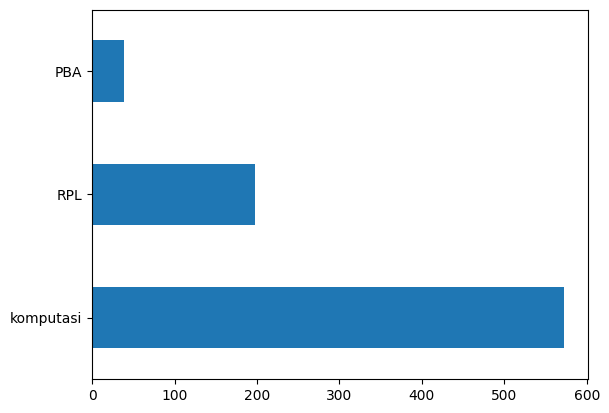

In [105]:
import matplotlib.pyplot as plt
df['Label'].value_counts().plot(kind='barh')
plt.show()

In [106]:
# Menghitung jumlah data pada masing-masing label
df['Label'].value_counts()

komputasi    573
RPL          198
PBA           39
Name: Label, dtype: int64

In [64]:
label = df["Label"]

In [65]:
abstract_datas = df["Abstrak"]

In [66]:
abstract_datas.head(10)

0    Sistem  informasi  akademik  (SIAKAD) merupaka...
1    Berjalannya koneksi jaringan komputer dengan l...
2    Web server adalah sebuah perangkat lunak serve...
3    Penjadwalan  kuliah  di  Perguruan  Tinggi  me...
4    Seiring perkembangan teknologi yang ada diduni...
5    Gerak pekerja ada pada game yang memiliki genr...
6    Perkembangan game yang semakin pesat, memberik...
7    Sistem pengenalan wajah adalah suatu sistem un...
8    Teknologi mobile game beroperating system open...
9    Kantor Badan Kepegawaian kota Bangkalan adalah...
Name: Abstrak, dtype: object

## Text Processing

### Text Cleaning

In [67]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [68]:
def preprocess(text):
    """convert to lowercase, strip and remove punctuations"""
    text = text.lower() 

    # remove whitespace
    text = text.strip() 
    # compile pattern that have `<.*?>` then replace with ''
    text = re.compile('<.*?>').sub('', text) 

    # compile pattern that have punctuation !"#$%&'()*+, -./:;<=>?@[\]^_`{|}~ then replace with ' '
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)

    # replace all one or more space to one space
    text = re.sub('\s+', ' ', text)

    # replace all number 0-9 to one space
    text = re.sub(r"\d+", "", text)

    # replace all first word or space in the beginning of line to ''
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

    # replace all digits to one space
    text = re.sub(r'\d',' ',text) 

    # replace all one or more space to one space
    text = re.sub(r'\s+',' ',text) 

    return text

def stopword(string):
    """Stopword removal like I, The, An, be, is, etc"""
    a = [i for i in string.split() if i not in stopwords.words('indonesian')]
    return ' '.join(a)

In [69]:
preprocessed_abstract = []
for text in abstract_datas:
    preprocessed_abstract.append(preprocess(str(text)))

In [70]:
preprocessed_abstract = pd.Series(preprocessed_abstract)

In [107]:
preprocessed_abstract

0      sistem informasi akademik siakad merupakan sis...
1      berjalannya koneksi jaringan komputer dengan l...
2      web server adalah sebuah perangkat lunak serve...
3      penjadwalan kuliah di perguruan tinggi merupak...
4      seiring perkembangan teknologi yang ada diduni...
                             ...                        
805    investasi saham selama ini memiliki resiko ker...
806    information retrieval ir merupakan pengambilan...
807    klasifikasi citra merupakan proses pengelompok...
808    identifikasi atribut pejalan kaki merupakan sa...
809    topik deteksi objek telah menarik perhatian ya...
Length: 810, dtype: object

## Stop Words Removal
> Menghilangkan kata yang tidak diperlukan

In [72]:
removed_stopword_abstract = []
for text in preprocessed_abstract:
    removed_stopword_abstract.append(stopword(str(text)))

In [73]:
removed_stopword_abstract = pd.Series(removed_stopword_abstract)

In [108]:
removed_stopword_abstract

0      sistem informasi akademik siakad sistem inform...
1      berjalannya koneksi jaringan komputer lancar g...
2      web server perangkat lunak server berfungsimen...
3      penjadwalan kuliah perguruan kompleks permasal...
4      seiring perkembangan teknologi didunia muncul ...
                             ...                        
805    investasi saham memiliki resiko kerugian dikar...
806    information retrieval ir pengambilan informasi...
807    klasifikasi citra proses pengelompokan piksel ...
808    identifikasi atribut pejalan kaki salah peneli...
809    topik deteksi objek menarik perhatian perkemba...
Length: 810, dtype: object

## Stemming
> Mengubah Kata Kerja Menjadi Kata Dasar

In [75]:
# stemming for Indonesian Language
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def to_base_word(string):
    """Change words to base words"""
    string = string.split()
    text = [stemmer.stem(word) for word in string]
    return ' '.join(text)

In [76]:
cleaned_abstract = []
for text in removed_stopword_abstract:
    cleaned_abstract.append(to_base_word(str(text)))

In [77]:
cleaned_abstract = pd.Series(cleaned_abstract)

In [109]:
cleaned_abstract

0      sistem informasi akademik siakad sistem inform...
1      jalan koneksi jaring komputer lancar ganggu ha...
2      web server perangkat lunak server berfungsimen...
3      jadwal kuliah guru kompleks masalah variabel t...
4      iring kembang teknologi dunia muncul teknologi...
                             ...                        
805    investasi saham milik resiko rugi dikarenakanp...
806    information retrieval ir ambil informasi simpa...
807    klasifikasi citra proses kelompok piksel citra...
808    identifikasi atribut pejal kaki salah teliti k...
809    topik deteksi objek tarik perhati kembang tekn...
Length: 810, dtype: object

## Tokenization

In [79]:
import gensim
from gensim.models import Word2Vec


In [80]:
# Python program to generate word vectors using Word2Vec
data = []
# iterate through each sentence in the file
for text in cleaned_abstract:
    for i in sent_tokenize(text):
        temp = []
        
        # tokenize the sentence into words
        for j in word_tokenize(i):
            temp.append(j.lower())
    
        data.append(temp)

In [81]:
len(data)

810

## Feature Extraction

### Dummy Data

In [82]:
first_word1 = "sistem"
first_word2 = "game"
first_word3 = "komputasi"

second_word1 = "perangkat"
second_word2 = "perangkat"
second_word3 = "perangkat"

### Words Embedding - Continous Bag of Word Model (CBOW)
```CBOW merupakan model yang memprediksi current word (sebagai target) dari konteks (sebagai input) di sekitarnya[4]. bisa dikatakan bahwa CBOW merupakan kebalikan dari Skip-Gram, dimana CBOW pun akan mempelajari distribusi probabilitas dari konteks dengan windows yang telah di tentukan. konteks yang digunakan serupa dengan konteks pada ilustrasi implementasi Skip-Gram sehingga menggunakan one-hot encoded vectors yang serupa.```

In [83]:
# Create CBOW model
cbow_model = gensim.models.Word2Vec(data, min_count = 1, vector_size = 100, window = 5)

In [84]:
result_with_cbow = cbow_model.wv.similarity(first_word1, second_word1)
print(f"Cosine similarity between '{first_word1}' and '{second_word1}' - with CBOW : {result_with_cbow}")

Cosine similarity between 'sistem' and 'perangkat' - with CBOW : 0.9708698391914368


In [85]:
result_with_cbow = cbow_model.wv.similarity(first_word2, second_word2)
print(f"Cosine similarity between '{first_word2}' and '{second_word2}' - with CBOW : {result_with_cbow}")

Cosine similarity between 'game' and 'perangkat' - with CBOW : 0.9869017601013184


In [86]:
result_with_cbow = cbow_model.wv.similarity(first_word3, second_word3)
print(f"Cosine similarity between '{first_word3}' and '{second_word3}' - with CBOW : {result_with_cbow}")

Cosine similarity between 'komputasi' and 'perangkat' - with CBOW : 0.9895973205566406


### Word Embedding - Skip-Gram
```Skip-Gram merupakan model yang diperkenalkan oleh Mikolov et al[3]. Ilustrasi feeding forward Skip-Gram dengan windows (jarak antara kata-kata konteks dengan posisi kata yang menjadi inputan) = 2. Secara Arsitektur Skip-Gram menggunakan current word (sebagai input) untuk memprediksi konteks (sebagai target) disekitarnya, dimana Skip-Gram akan mempelajari distribusi probabilitas dari kata-kata didalam konteks dengan windows yang telah di tentukan. Misal konteks yang digunakan saat ini adalah “the best revenge is massive success” dengan nilai windows = 2.```

In [87]:
# Create Skip Gram model
skip_gram_model = gensim.models.Word2Vec(data, min_count = 1, vector_size = 100,window = 5, sg = 1)

In [88]:
result_with_cbow = skip_gram_model.wv.similarity(first_word1, second_word1)
print(f"Cosine similarity between '{first_word1}' and '{second_word1}' - with CBOW : {result_with_cbow}")

Cosine similarity between 'sistem' and 'perangkat' - with CBOW : 0.7010038495063782


In [89]:
result_with_cbow = skip_gram_model.wv.similarity(first_word2, second_word2)
print(f"Cosine similarity between '{first_word2}' and '{second_word2}' - with CBOW : {result_with_cbow}")

Cosine similarity between 'game' and 'perangkat' - with CBOW : 0.7416724562644958


In [90]:
result_with_cbow = skip_gram_model.wv.similarity(first_word3, second_word3)
print(f"Cosine similarity between '{first_word3}' and '{second_word3}' - with CBOW : {result_with_cbow}")

Cosine similarity between 'komputasi' and 'perangkat' - with CBOW : 0.5798681378364563


## Modelling

 ```y``` label

---



In [91]:
print(label.unique())

['RPL' 'komputasi' 'PBA']


 ```X``` label

In [92]:
cleaned_abstract

0      sistem informasi akademik siakad sistem inform...
1      jalan koneksi jaring komputer lancar ganggu ha...
2      web server perangkat lunak server berfungsimen...
3      jadwal kuliah guru kompleks masalah variabel t...
4      iring kembang teknologi dunia muncul teknologi...
                             ...                        
805    investasi saham milik resiko rugi dikarenakanp...
806    information retrieval ir ambil informasi simpa...
807    klasifikasi citra proses kelompok piksel citra...
808    identifikasi atribut pejal kaki salah teliti k...
809    topik deteksi objek tarik perhati kembang tekn...
Length: 810, dtype: object

>Merge Data

In [93]:
new_data = {"Abstract" : cleaned_abstract, "Label" : label}
new_df = pd.concat(new_data, axis = 1)

In [94]:
new_df

,Abstract,Label
0,sistem informasi akademik siakad sistem inform...,RPL
1,jalan koneksi jaring komputer lancar ganggu ha...,RPL
2,web server perangkat lunak server berfungsimen...,RPL
3,jadwal kuliah guru kompleks masalah variabel t...,komputasi
4,iring kembang teknologi dunia muncul teknologi...,komputasi
...,...,...
805,investasi saham milik resiko rugi dikarenakanp...,komputasi
806,information retrieval ir ambil informasi simpa...,PBA
807,klasifikasi citra proses kelompok piksel citra...,komputasi
808,identifikasi atribut pejal kaki salah teliti k...,komputasi


load one of the models listed at https://github.com/MartinoMensio/spacy-sentence-bert/

In [95]:
# for model paraphrase-xlm-r-multilingual-v1
# nlp = spacy_sentence_bert.load_model('xx_paraphrase_xlm_r_multilingual_v1')

# for model distiluse-base-multilingual-cased-v2
nlp = spacy_sentence_bert.load_model('xx_distiluse_base_multilingual_cased_v2')

create ```df['vector']``` where individual abstract are represented as real-valued vectors in a lower-dimensional space

In [96]:
new_df['vector'] = new_df['Abstract'].apply(lambda x: nlp(x).vector)

In [97]:
new_df

,Abstract,Label,vector
0,sistem informasi akademik siakad sistem inform...,RPL,"[0.031695787, 0.0023456903, 0.024228334, -0.02..."
1,jalan koneksi jaring komputer lancar ganggu ha...,RPL,"[0.05129609, -0.024710625, 0.0071516503, 0.005..."
2,web server perangkat lunak server berfungsimen...,RPL,"[-0.01809457, 0.008628295, 0.018115576, -0.045..."
3,jadwal kuliah guru kompleks masalah variabel t...,komputasi,"[0.022376867, 0.04639911, 0.023099931, -0.0318..."
4,iring kembang teknologi dunia muncul teknologi...,komputasi,"[0.017368551, 0.012109199, 0.0017237976, -0.03..."
...,...,...,...
805,investasi saham milik resiko rugi dikarenakanp...,komputasi,"[0.069311306, -0.045802895, -0.037823424, -0.0..."
806,information retrieval ir ambil informasi simpa...,PBA,"[0.01896165, 0.058011252, 0.005346107, -0.0410..."
807,klasifikasi citra proses kelompok piksel citra...,komputasi,"[-0.0014633666, 0.013076945, 0.013453842, -0.0..."
808,identifikasi atribut pejal kaki salah teliti k...,komputasi,"[0.008453492, 0.016413404, 0.040197723, -0.015..."


### Split Data

Split X and y as below


*   ```X_train``` train X data 
*   ```X_test``` test X data 


*   ```y_train``` train y data 
*   ```y_test``` test y data 



In [110]:
X_train, X_test, y_train, y_test = train_test_split(new_df['vector'].tolist(), new_df['Label'].tolist(), test_size=0.3, random_state=42)

### Train Data

#### K-NN

In [122]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

modelKNN = KNeighborsClassifier(n_neighbors=5)
modelKNN.fit(X_train, y_train)
test_pred = modelKNN.predict(X_test)
accuracy_score(y_test, y_pred)

0.7695473251028807

#### Naive Bayes

In [120]:
#Model Select
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
predict = gaussian.predict(X_test) 
accuracy_score(y_test, y_pred)

0.7695473251028807

#### SVC

In [111]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

clf = SVC(gamma='auto')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7119341563786008


#### Random Forest Classifier

In [112]:
clf = RandomForestClassifier(max_depth=9, random_state=0)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.7695473251028807


### Classification Test

Given dummy data to classify 


*   ```abstracts``` as data 
*   ```labels``` as category



In [123]:
abstracts = [
    "Spare part merupakan salah satu bagian penting dalam pengoperasian mesin pada sepeda motor. Peningkatan jumlah penjualan spare part yang tidak terduga saat proses tune-up menyebabkan kesulitan dalam pelayanan yang terbaik kepada konsumen. Demikian juga sebaliknya, apabila terjadi penurunan jumlah penjualan spare part, maka akan menyebabkan penumpukan spare part di gudang. Oleh karena itu diperlukan sistem peramalan yang mampu meramalkan penjualan spare part pada periode berikutnya. Sistem peramalan ini menggunakan metode Jaringan Syaraf Tiruan algoritma Propagasi Balik dengan momentum untuk meramalkan jumlah penjualan spare part  pada bulan berikutnya. Data yang telah tersimpan dihitung menggunakan epoh dan learning rate yang berbeda. Dari hasil uji coba system, maka dapat disimpulkan bahwa  dengan menggunakan semua data sebagai data training dan menggunakan learning rate 3.5 dan dengan epoh 200 akan menghasilkan tingkat kesalahan 0.0622716."]

labels = [
    'RPL'
]

> Result


In [124]:
for abstract, label in zip(abstracts, labels):
  print(abstract)
  print(f"True Label: {label}, Predicted Label: {clf.predict(nlp(abstract).vector.reshape(1, -1))[0]} \n")

Spare part merupakan salah satu bagian penting dalam pengoperasian mesin pada sepeda motor. Peningkatan jumlah penjualan spare part yang tidak terduga saat proses tune-up menyebabkan kesulitan dalam pelayanan yang terbaik kepada konsumen. Demikian juga sebaliknya, apabila terjadi penurunan jumlah penjualan spare part, maka akan menyebabkan penumpukan spare part di gudang. Oleh karena itu diperlukan sistem peramalan yang mampu meramalkan penjualan spare part pada periode berikutnya. Sistem peramalan ini menggunakan metode Jaringan Syaraf Tiruan algoritma Propagasi Balik dengan momentum untuk meramalkan jumlah penjualan spare part  pada bulan berikutnya. Data yang telah tersimpan dihitung menggunakan epoh dan learning rate yang berbeda. Dari hasil uji coba system, maka dapat disimpulkan bahwa  dengan menggunakan semua data sebagai data training dan menggunakan learning rate 3.5 dan dengan epoh 200 akan menghasilkan tingkat kesalahan 0.0622716.
True Label: RPL, Predicted Label: komputasi 